In [16]:
import lightgbm
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import random
import os

# 시드 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    lightgbm.seed = seed

set_seed(42)

In [17]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd

data = pd.read_csv('/Users/baby_cow/Desktop/AI/ML_competition/data/geocoded_addresses_12.csv')
data.columns

Index(['Unnamed: 0', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '거래유형', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'latitude',
       'longitude', 'address', 'address_apt', 'address_apt_sqm', '구', '동',
       '강남여부', 'mean_target', 'apt_mean_target', 'address_mean_target',
       'mean_target_gu_dong', 'closest_bus_stop_distance',
       'closest_subway_station_distance', 'bus_stop_count_500m',
       'subway_station_count_500m', 'bus_stop_count_750m',
       'subway_station_count_750m', 'bus_stop_count_1000m',
       'subway_station_count_1000m', 'square_meter',
       'monthly_mean_target_rate', 'adjusted_square_meter', 'is_outlier',
       'year', 'month', 'distance_to_lead_house'],
      dtype='object')

In [18]:
temp_index = list(range(len(data)))
data['id'] = temp_index
selected_columns = ['id', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '구', '동', '건축년도','주차대수', '강남여부',
                    'closest_bus_stop_distance','closest_subway_station_distance', 'bus_stop_count_500m',
                    'subway_station_count_500m', 'bus_stop_count_750m',
                    'subway_station_count_750m', 'bus_stop_count_1000m',
                    'subway_station_count_1000m', 'distance_to_lead_house', 'is_test', 'target', 'apt_mean_target', 'mean_target']

df = data[selected_columns]

df['전용면적'] = df['전용면적(㎡)']
df.drop(columns=['전용면적(㎡)'], axis=1, inplace=True)

df['계약년'] = df['계약년월'].map(lambda x : int(str(x)[:4]))

df.head()

,id,아파트명,계약년월,계약일,층,구,동,건축년도,주차대수,강남여부,...,subway_station_count_750m,bus_stop_count_1000m,subway_station_count_1000m,distance_to_lead_house,is_test,target,apt_mean_target,mean_target,전용면적,계약년
0,0,개포6차우성,2017-12-01,8,3,강남구,개포동,1987,262.0,1,...,0,57,0,6.609733,0,124000.0,104403.465347,119240.517241,79.97,2017
1,1,개포6차우성,2017-12-01,22,4,강남구,개포동,1987,262.0,1,...,0,57,0,6.609733,0,123500.0,104403.465347,119240.517241,79.97,2017
2,2,개포6차우성,2017-12-01,28,5,강남구,개포동,1987,262.0,1,...,0,57,0,6.609733,0,91500.0,104403.465347,86362.500000,54.98,2017
3,3,개포6차우성,2018-01-01,3,4,강남구,개포동,1987,262.0,1,...,0,57,0,6.609733,0,130000.0,104403.465347,119240.517241,79.97,2018
4,4,개포6차우성,2018-01-01,8,2,강남구,개포동,1987,262.0,1,...,0,57,0,6.609733,0,117000.0,104403.465347,119240.517241,79.97,2018


# 지역별 chunk 나누기

In [19]:
chunks = {}

regions = df['구'].unique()

for region in regions:
    chunk = df[df['구'] == region]
    chunk.sort_values(by='계약년월')
    chunks[region] = chunk

# 올해 + 1년 전 우리 구 평균 부동산 가격 피쳐 만들기

In [20]:
from IPython.display import display

for region in regions:
    chunk = chunks[region]

    year_target_means = {}

    for year in range(2007, 2024):
        this_year_target_mean = chunk.loc[(chunk['계약년'] == year) & (chunk['is_test'] == 0) ,'target'].mean()
        chunk.loc[(chunk['계약년'] == year) , '올해 지역 평균'] =  this_year_target_mean
        year_target_means[year] = this_year_target_mean

        if year == 2007:
            chunk.loc[(chunk['계약년'] == year), '작년 지역 평균'] = this_year_target_mean
        else:
            chunk.loc[(chunk['계약년'] == year), '작년 지역 평균'] = year_target_means[year-1]
    
    chunks[region] = chunk

# 모델 학습

In [37]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

result_board = []
result = pd.DataFrame()
trained_models = {}

params = {
    'objective': 'regression', 
    'metric': 'rmse',           
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'lambda_l2' : 0.1,
    'drop_rate' : 0.2,
    'verbose' : -1
}

pred_chunks = {}

for region in tqdm(regions):
    chunk = chunks[region]

    select_cols = ['id','층', '건축년도','주차대수',
        'closest_bus_stop_distance', 'closest_subway_station_distance',
        'bus_stop_count_500m', 'subway_station_count_500m',
        'bus_stop_count_750m', 'subway_station_count_750m',
        'bus_stop_count_1000m', 'subway_station_count_1000m',
        'distance_to_lead_house', 'is_test', 'target', '전용면적', '계약년',
        '올해 지역 평균', '작년 지역 평균', 'apt_mean_target', 'mean_target']
    
    chunk = chunk[select_cols]

    train_chunk = chunk.query('is_test == 0')
    test_chunk = chunk.query('is_test == 1')

    train_chunk.drop(columns=['is_test', 'id'], axis=1, inplace = True)
    test_chunk.drop(columns = ['is_test'], axis = 1, inplace = True)

    X = train_chunk.drop(columns=['target'], axis=1)
    y = train_chunk['target']

    tscv = TimeSeriesSplit(n_splits = 17)
    
    min_rmse = int(1e9)

    model = None
    for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label = y_train)
        val_data = lgb.Dataset(X_val, label = y_val, reference = train_data)

        if model :
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                init_model = model,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        else:
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        min_rmse = min(min_rmse, rmse)

    result_board.append({"지역" : region, "validation RMSE" : min_rmse})

    X_val['pred_target'] = y_pred
    X_val['target'] = y_val
    pred_chunks[region] = X_val

    final_train_data = lgb.Dataset(X, label=y)
    final_model = lgb.train(params,
                            final_train_data,
                            init_model = model,
                            num_boost_round=model.best_iteration,
                            callbacks = [lgb.log_evaluation(period=-1)],
                            )
    
    trained_models[region] = final_model

    test_X = test_chunk.drop(columns=['id', 'target'], axis=1)
    pred = final_model.predict(test_X)

    test_chunk['target'] = pred

    result = pd.concat([result, test_chunk[['id', 'target']]]) 


  0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	training's rmse: 12579.4	valid_1's rmse: 43820.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	training's rmse: 12951.3	valid_1's rmse: 14445.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[69]	training's rmse: 11681.5	valid_1's rmse: 49056.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[82]	training's rmse: 14478	valid_1's rmse: 41553.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[149]	training's rmse: 14475.8	valid_1's rmse: 24352.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[151]	training's rmse: 16015.9	valid_1's rmse: 24489.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[183]	train

  4%|▍         | 1/25 [00:07<02:57,  7.41s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	training's rmse: 7031.39	valid_1's rmse: 16047.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	training's rmse: 4117.63	valid_1's rmse: 7329.12
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	training's rmse: 4092.97	valid_1's rmse: 15360.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[130]	training's rmse: 4025	valid_1's rmse: 28412
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[140]	training's rmse: 7081.93	valid_1's rmse: 11149.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[146]	training's rmse: 6676.37	valid_1's rmse: 7765.14
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[148]	trainin

  8%|▊         | 2/25 [00:13<02:31,  6.60s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	training's rmse: 2482.24	valid_1's rmse: 6225.72
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[128]	training's rmse: 2403.18	valid_1's rmse: 3276.25
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[130]	training's rmse: 2591.27	valid_1's rmse: 23948.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[152]	training's rmse: 3246.47	valid_1's rmse: 8054.69
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[153]	training's rmse: 4443.08	valid_1's rmse: 10142.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[181]	training's rmse: 3559.13	valid_1's rmse: 6440.28
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[202]	

 12%|█▏        | 3/25 [00:17<02:01,  5.53s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	training's rmse: 3781.77	valid_1's rmse: 10560
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	training's rmse: 3636.62	valid_1's rmse: 5580.14
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[81]	training's rmse: 4233.15	valid_1's rmse: 25809.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[101]	training's rmse: 4909.33	valid_1's rmse: 8363.51
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[126]	training's rmse: 4854.46	valid_1's rmse: 7941.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[127]	training's rmse: 5373.7	valid_1's rmse: 7538.58
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[128]	train

 16%|█▌        | 4/25 [00:25<02:14,  6.41s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[32]	training's rmse: 3288.75	valid_1's rmse: 8219.54
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[70]	training's rmse: 2900.19	valid_1's rmse: 3841.93
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	training's rmse: 2986	valid_1's rmse: 27920.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[96]	training's rmse: 4178.27	valid_1's rmse: 8661.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[118]	training's rmse: 4067.42	valid_1's rmse: 10208.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[131]	training's rmse: 4244.32	valid_1's rmse: 6621.67
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[135]	trainin

 20%|██        | 5/25 [00:31<02:04,  6.22s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	training's rmse: 5240.94	valid_1's rmse: 16740
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[84]	training's rmse: 5170.23	valid_1's rmse: 7686.18
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[86]	training's rmse: 5845.43	valid_1's rmse: 34391.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[105]	training's rmse: 7565.02	valid_1's rmse: 18376.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[115]	training's rmse: 8328.44	valid_1's rmse: 16769.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[116]	training's rmse: 9873.67	valid_1's rmse: 12557.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[127]	trai

 24%|██▍       | 6/25 [00:35<01:46,  5.58s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[40]	training's rmse: 2646.81	valid_1's rmse: 9003.23
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	training's rmse: 3165.85	valid_1's rmse: 5520.22
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[81]	training's rmse: 2826.51	valid_1's rmse: 17138.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[99]	training's rmse: 3830.98	valid_1's rmse: 8022.56
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[118]	training's rmse: 3894.3	valid_1's rmse: 6988.76
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[131]	training's rmse: 3924.89	valid_1's rmse: 6807.42
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[152]	trai

 28%|██▊       | 7/25 [00:42<01:45,  5.85s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	training's rmse: 1826.5	valid_1's rmse: 6420.22
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[79]	training's rmse: 2058.94	valid_1's rmse: 9681.14
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[163]	training's rmse: 1881.36	valid_1's rmse: 16443.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[179]	training's rmse: 3319.02	valid_1's rmse: 7201.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[182]	training's rmse: 3974.26	valid_1's rmse: 6849.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[189]	training's rmse: 3811.67	valid_1's rmse: 3587.21
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[190]	tra

 32%|███▏      | 8/25 [00:46<01:29,  5.28s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	training's rmse: 2284.63	valid_1's rmse: 7209.36
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	training's rmse: 2459.41	valid_1's rmse: 3366.02
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[87]	training's rmse: 2540.27	valid_1's rmse: 27237.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[109]	training's rmse: 3674.6	valid_1's rmse: 8835.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[115]	training's rmse: 4215.15	valid_1's rmse: 8751.16
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[120]	training's rmse: 4532.23	valid_1's rmse: 3447.71
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[132]	tra

 36%|███▌      | 9/25 [00:55<01:45,  6.56s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	training's rmse: 2125.06	valid_1's rmse: 6565.94
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[79]	training's rmse: 2070.23	valid_1's rmse: 4930.95
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[135]	training's rmse: 2098.94	valid_1's rmse: 12678.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[146]	training's rmse: 3816.31	valid_1's rmse: 8168.43
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[150]	training's rmse: 4387.12	valid_1's rmse: 6172.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[156]	training's rmse: 4162.01	valid_1's rmse: 3789.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[159]	tra

 40%|████      | 10/25 [01:01<01:36,  6.40s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[63]	training's rmse: 3738.54	valid_1's rmse: 7331.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[101]	training's rmse: 3278.23	valid_1's rmse: 5295.06
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[219]	training's rmse: 2806.05	valid_1's rmse: 19910.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[243]	training's rmse: 4041.47	valid_1's rmse: 9641.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[272]	training's rmse: 4396.55	valid_1's rmse: 9010.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[310]	training's rmse: 4275.1	valid_1's rmse: 6927.47
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[317]	tra

 44%|████▍     | 11/25 [01:09<01:35,  6.85s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	training's rmse: 4744.84	valid_1's rmse: 12374.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[183]	training's rmse: 4027.48	valid_1's rmse: 5937.67
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[211]	training's rmse: 4096.72	valid_1's rmse: 39616.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[230]	training's rmse: 6542	valid_1's rmse: 12392.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[236]	training's rmse: 7075.34	valid_1's rmse: 10849.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[237]	training's rmse: 7636.19	valid_1's rmse: 7561.24
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[267]	tra

 48%|████▊     | 12/25 [01:17<01:32,  7.10s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[50]	training's rmse: 5960.83	valid_1's rmse: 13157.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	training's rmse: 5945.46	valid_1's rmse: 6317.44
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[81]	training's rmse: 5972.24	valid_1's rmse: 35496.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[103]	training's rmse: 7283.69	valid_1's rmse: 13132.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[211]	training's rmse: 5983.15	valid_1's rmse: 11300.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[264]	training's rmse: 5936.44	valid_1's rmse: 10132.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[292]	tr

 52%|█████▏    | 13/25 [01:24<01:27,  7.32s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	training's rmse: 4774.81	valid_1's rmse: 8194.21
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[123]	training's rmse: 3875.02	valid_1's rmse: 6004.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[198]	training's rmse: 3470.33	valid_1's rmse: 20583.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[211]	training's rmse: 5650.47	valid_1's rmse: 10616.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[220]	training's rmse: 5764.61	valid_1's rmse: 8555.39
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[233]	training's rmse: 5581.35	valid_1's rmse: 6982.44
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[234]	t

 56%|█████▌    | 14/25 [01:31<01:18,  7.15s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	training's rmse: 10215.7	valid_1's rmse: 38531.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[112]	training's rmse: 9943.35	valid_1's rmse: 14483
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[151]	training's rmse: 9399.85	valid_1's rmse: 64470.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[160]	training's rmse: 17406.4	valid_1's rmse: 31309.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[193]	training's rmse: 13782.8	valid_1's rmse: 26555.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[201]	training's rmse: 14621.7	valid_1's rmse: 17576.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[202]	tr

 60%|██████    | 15/25 [01:39<01:12,  7.24s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[53]	training's rmse: 7214.49	valid_1's rmse: 15219.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	training's rmse: 6192.06	valid_1's rmse: 6069.03
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	training's rmse: 5682.6	valid_1's rmse: 55695.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[105]	training's rmse: 11688.9	valid_1's rmse: 17680.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[141]	training's rmse: 10098	valid_1's rmse: 16283
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[161]	training's rmse: 9485.98	valid_1's rmse: 10516.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[196]	trainin

 64%|██████▍   | 16/25 [01:45<01:02,  6.94s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	training's rmse: 3757.03	valid_1's rmse: 6781.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	training's rmse: 3508.8	valid_1's rmse: 4636.56
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[78]	training's rmse: 3390.72	valid_1's rmse: 26992.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[97]	training's rmse: 4507.53	valid_1's rmse: 9707.85
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[112]	training's rmse: 4520.12	valid_1's rmse: 10650.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[146]	training's rmse: 4389.98	valid_1's rmse: 7278.42
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[212]	train

 68%|██████▊   | 17/25 [01:53<00:57,  7.19s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	training's rmse: 6651.31	valid_1's rmse: 25495.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	training's rmse: 6301.75	valid_1's rmse: 10072.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[127]	training's rmse: 5650.24	valid_1's rmse: 22099.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[200]	training's rmse: 5917.72	valid_1's rmse: 33923.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[208]	training's rmse: 10310.2	valid_1's rmse: 14289.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[210]	training's rmse: 10368.6	valid_1's rmse: 11317.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[213]	t

 72%|███████▏  | 18/25 [02:02<00:54,  7.74s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	training's rmse: 6660.73	valid_1's rmse: 14758.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	training's rmse: 4578.62	valid_1's rmse: 7815.03
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	training's rmse: 5103.87	valid_1's rmse: 18071.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[109]	training's rmse: 4895.02	valid_1's rmse: 25793.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[118]	training's rmse: 7332.63	valid_1's rmse: 11530.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[123]	training's rmse: 7081.42	valid_1's rmse: 9816.33
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[124]	tr

 76%|███████▌  | 19/25 [02:08<00:44,  7.45s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[73]	training's rmse: 4132.94	valid_1's rmse: 13629.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[108]	training's rmse: 4668.04	valid_1's rmse: 7579.85
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[146]	training's rmse: 4383.23	valid_1's rmse: 36954.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[163]	training's rmse: 6836.69	valid_1's rmse: 12725
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[257]	training's rmse: 5445.42	valid_1's rmse: 11133.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[273]	training's rmse: 5614.89	valid_1's rmse: 10103.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[277]	tr

 80%|████████  | 20/25 [02:18<00:41,  8.23s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[49]	training's rmse: 8550.44	valid_1's rmse: 75832.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	training's rmse: 11879.4	valid_1's rmse: 18106.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[102]	training's rmse: 9123.32	valid_1's rmse: 82271.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[109]	training's rmse: 24366.2	valid_1's rmse: 35000.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[124]	training's rmse: 18139.4	valid_1's rmse: 24152.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[144]	training's rmse: 15008.2	valid_1's rmse: 16253.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[165]	t

 84%|████████▍ | 21/25 [02:23<00:29,  7.26s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	training's rmse: 3063.53	valid_1's rmse: 8461.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[58]	training's rmse: 3474.83	valid_1's rmse: 5811.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[80]	training's rmse: 3208.03	valid_1's rmse: 21231.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[102]	training's rmse: 4417.41	valid_1's rmse: 8869.19
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[172]	training's rmse: 4097.24	valid_1's rmse: 8969.92
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[195]	training's rmse: 4110.2	valid_1's rmse: 9891.21
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[199]	train

 88%|████████▊ | 22/25 [02:30<00:21,  7.12s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[38]	training's rmse: 4819.68	valid_1's rmse: 11725.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[79]	training's rmse: 5111.05	valid_1's rmse: 11504
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[104]	training's rmse: 5414.72	valid_1's rmse: 26683.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[132]	training's rmse: 6666.61	valid_1's rmse: 15429.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[178]	training's rmse: 6467.73	valid_1's rmse: 13645
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[267]	training's rmse: 4833.01	valid_1's rmse: 11513.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[322]	train

 92%|█████████▏| 23/25 [02:35<00:12,  6.49s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	training's rmse: 4387.54	valid_1's rmse: 13850.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	training's rmse: 5610.33	valid_1's rmse: 12424.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[84]	training's rmse: 8180	valid_1's rmse: 35383.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[152]	training's rmse: 7695.94	valid_1's rmse: 14022.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[209]	training's rmse: 6933.01	valid_1's rmse: 18231.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[281]	training's rmse: 6241.21	valid_1's rmse: 8803.58
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[287]	train

 96%|█████████▌| 24/25 [02:40<00:05,  5.96s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[43]	training's rmse: 2764.98	valid_1's rmse: 5270.42
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	training's rmse: 2326.63	valid_1's rmse: 7300.96
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[163]	training's rmse: 2196.6	valid_1's rmse: 13835.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[177]	training's rmse: 3682.8	valid_1's rmse: 6480.78
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[182]	training's rmse: 3944.78	valid_1's rmse: 6396.55
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[188]	training's rmse: 3989.12	valid_1's rmse: 3777.52
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[191]	tra

100%|██████████| 25/25 [02:47<00:00,  6.68s/it]


# 결과 확인

In [38]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

3833.7420260389995


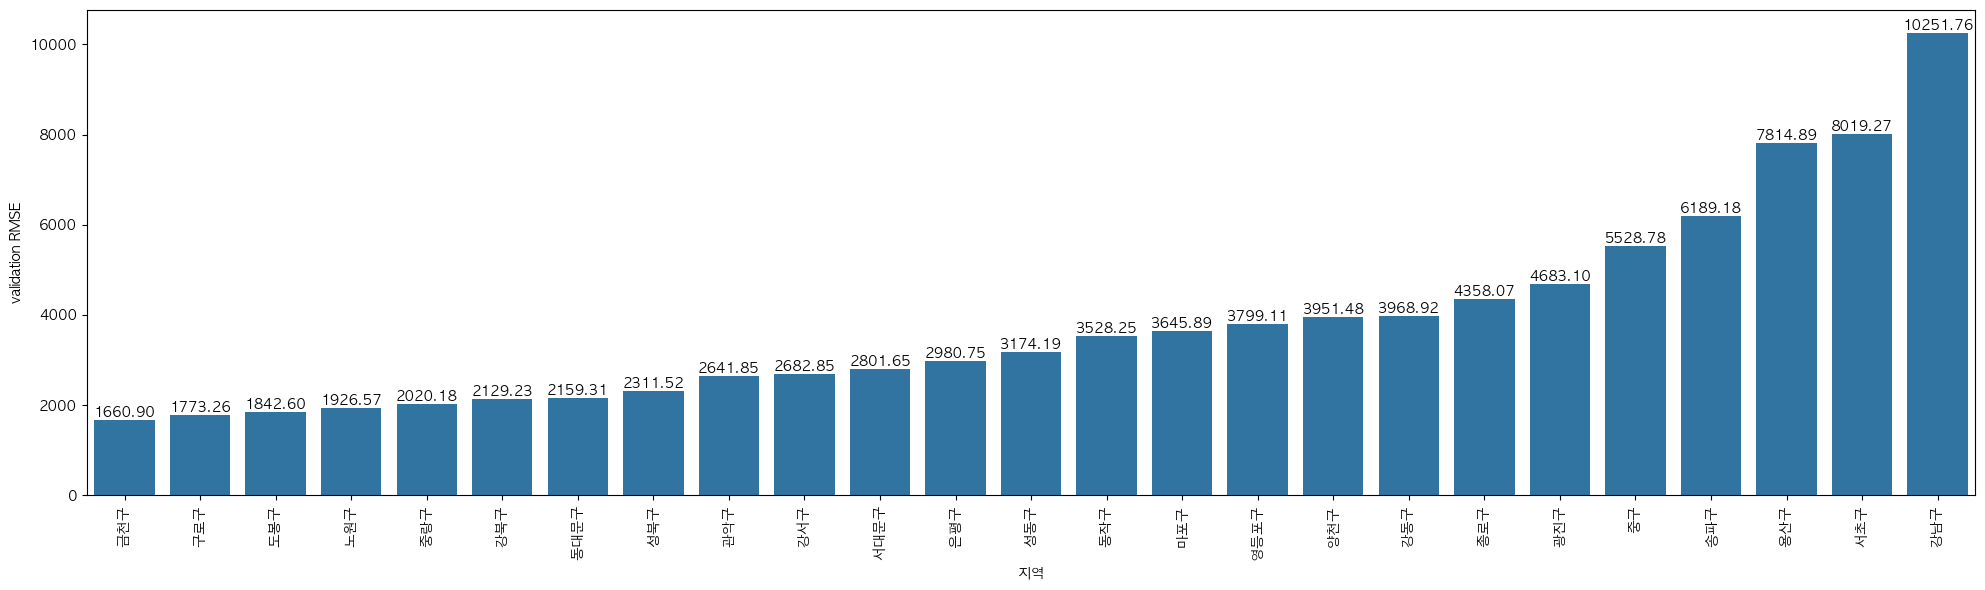

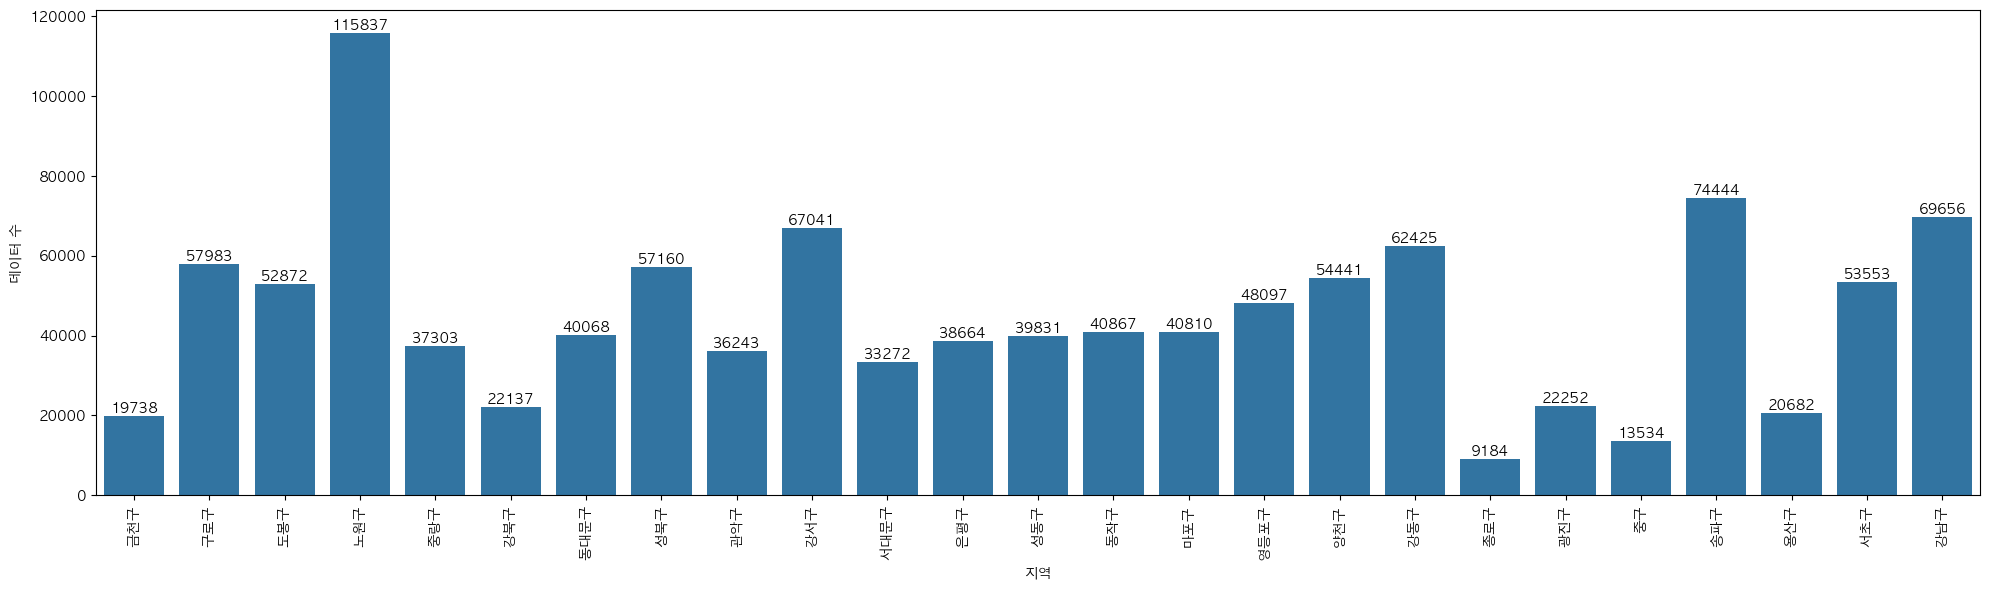

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

result_df = pd.DataFrame(result_board)
result_df = result_df.sort_values(by='validation RMSE')
result_df = result_df[-30:]

print(result_df['validation RMSE'].mean())

# 그래프 생성
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=result_df, x='지역', y='validation RMSE')

# 바 위에 값 표시
for i, v in enumerate(result_df['validation RMSE']):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


temp_list = [{"지역" : region, "데이터 수" : len(chunks[region])} for region in result_df['지역']]
temp_df = pd.DataFrame(temp_list)

plt.figure(figsize=(20, 6))
ax = sns.barplot(data = temp_df, x='지역', y='데이터 수')

# 바 위에 값 표시
for i, v in enumerate(temp_df['데이터 수']):
    ax.text(i, v, f'{v}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

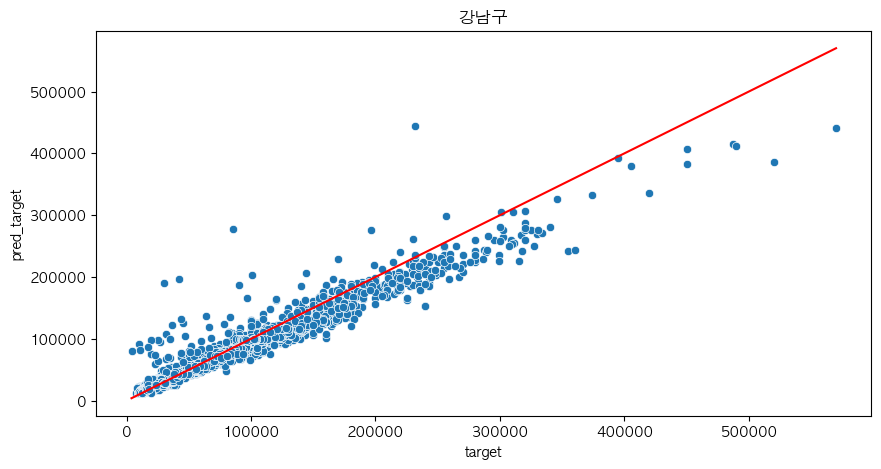

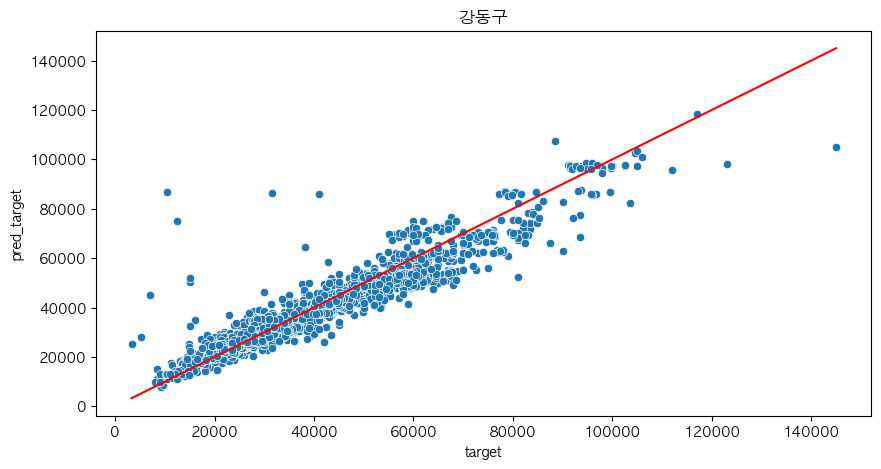

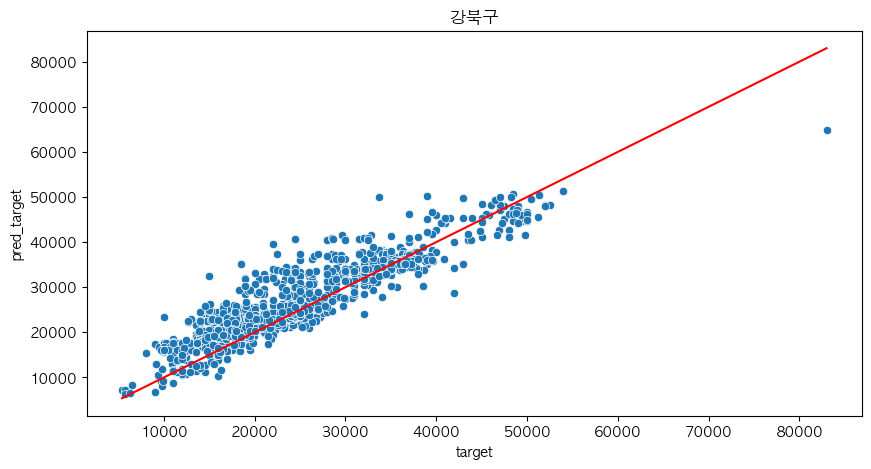

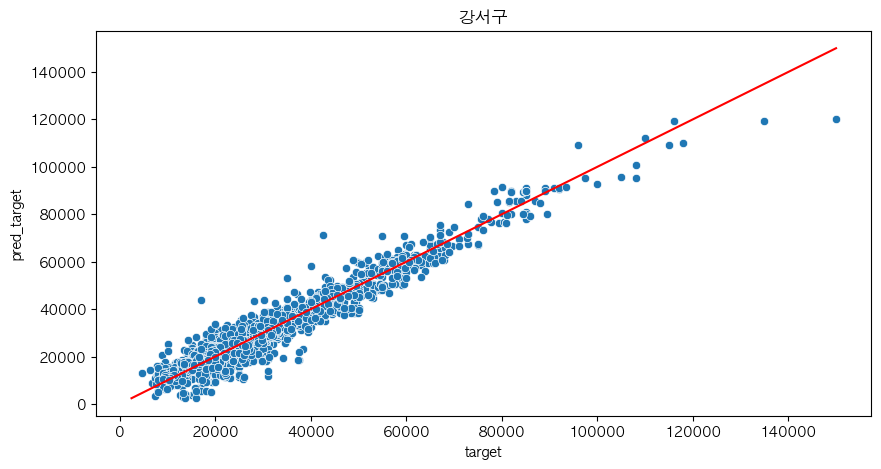

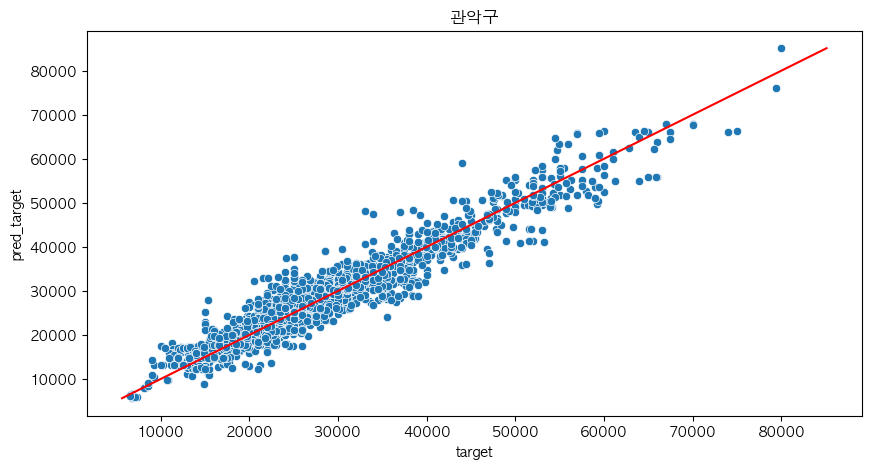

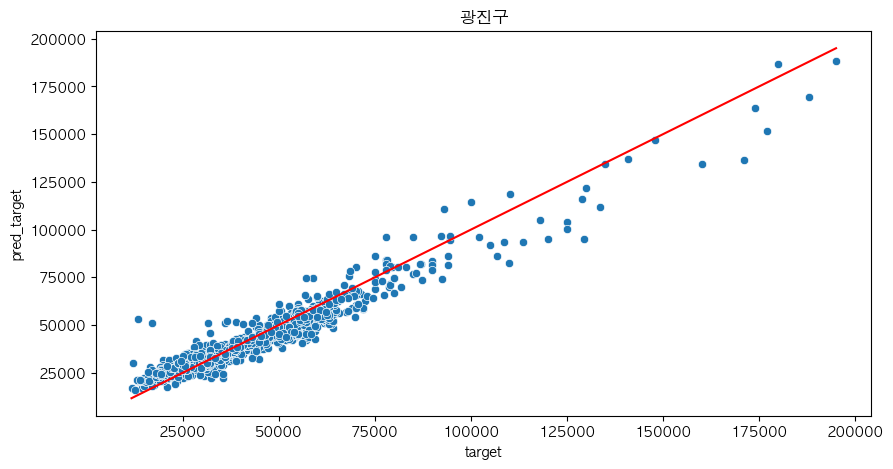

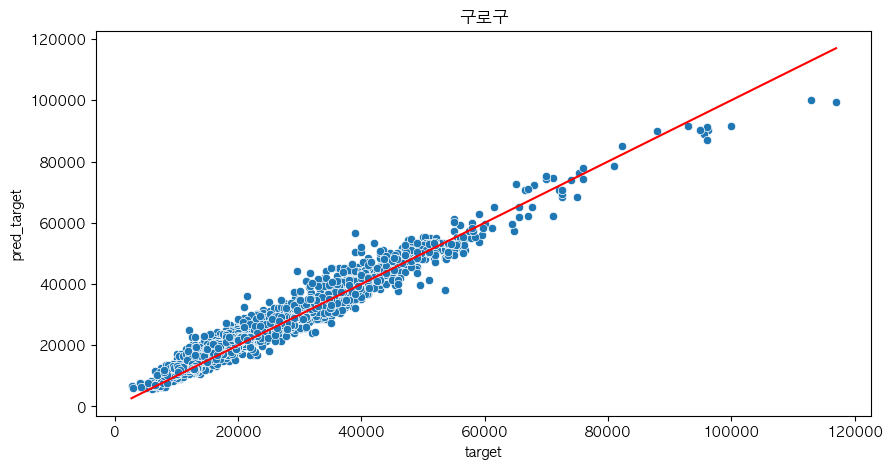

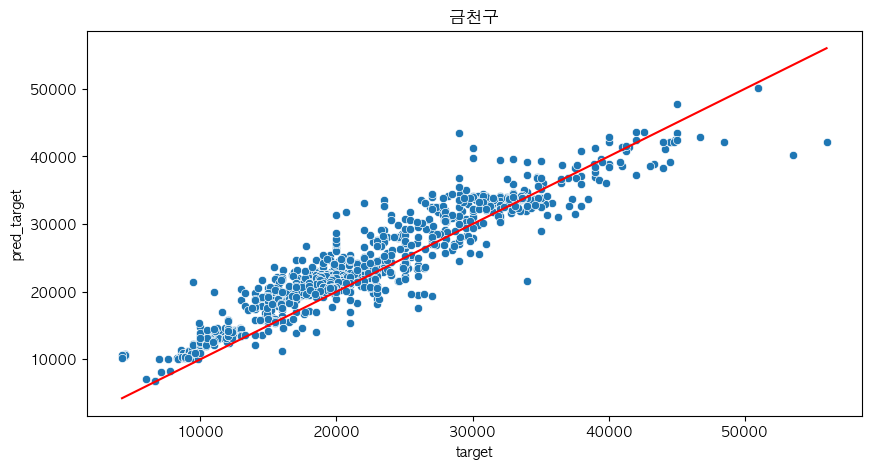

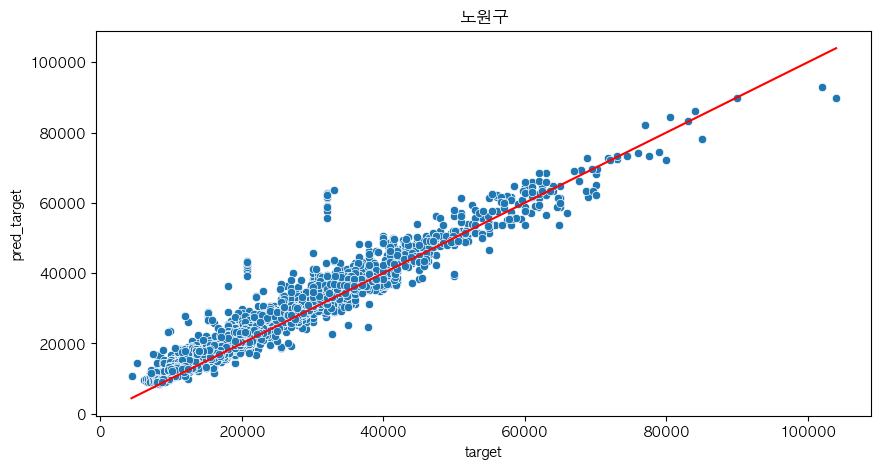

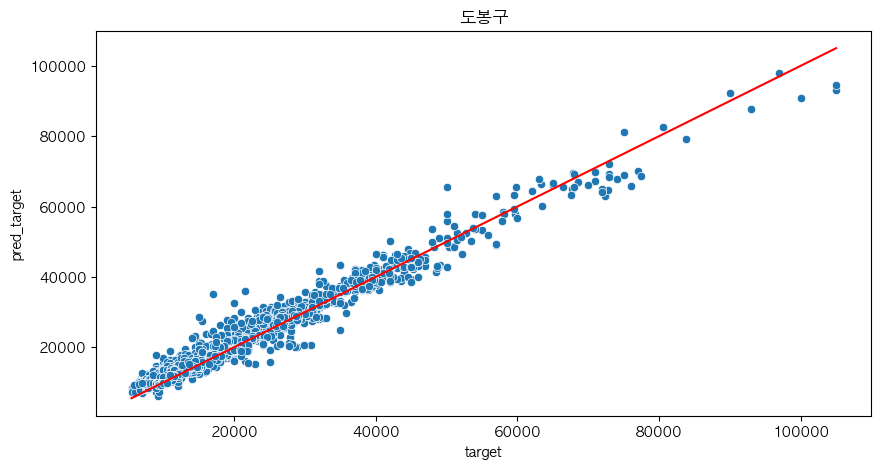

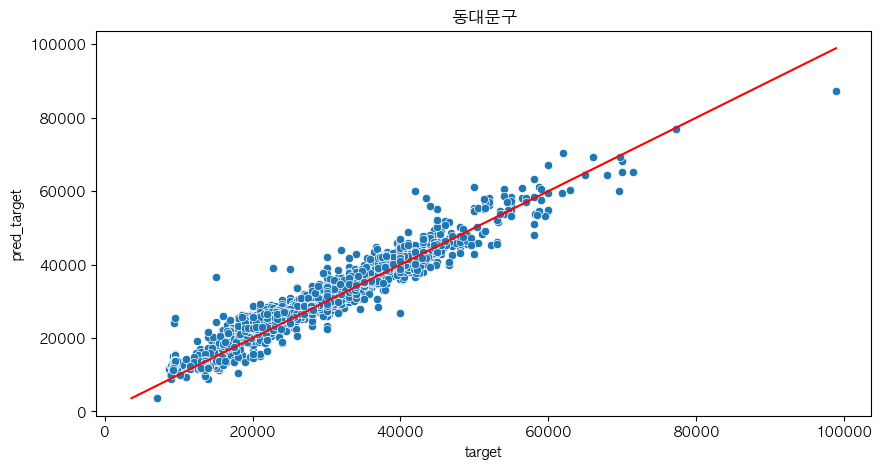

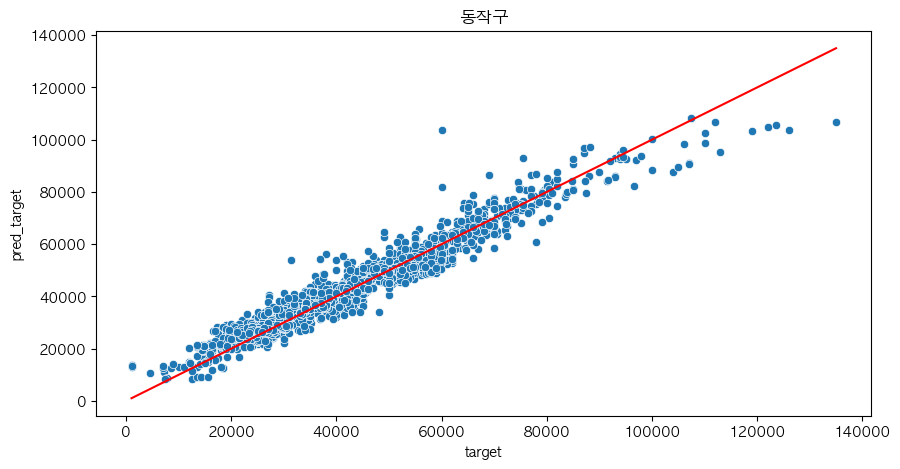

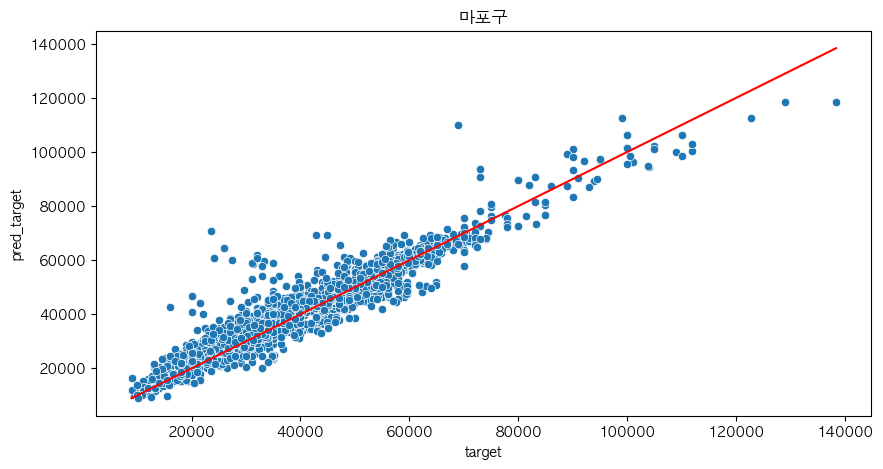

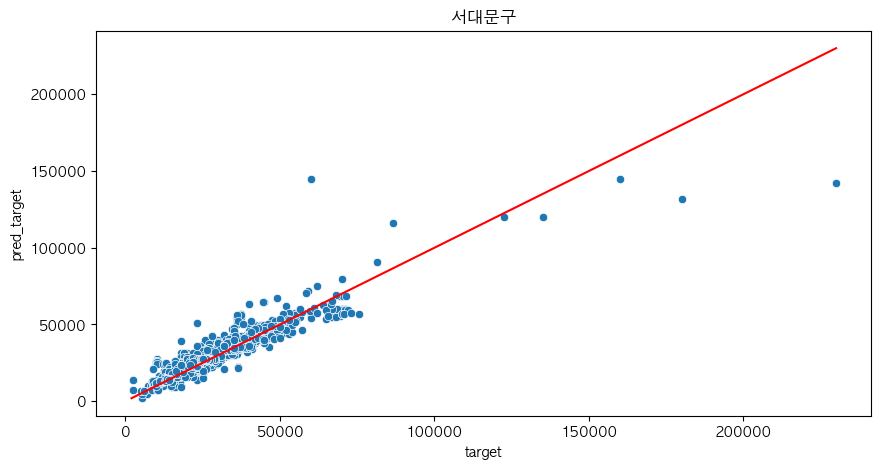

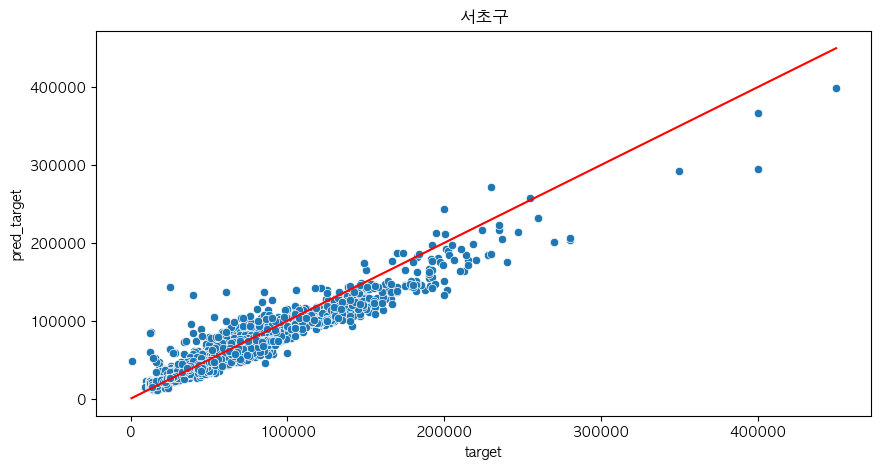

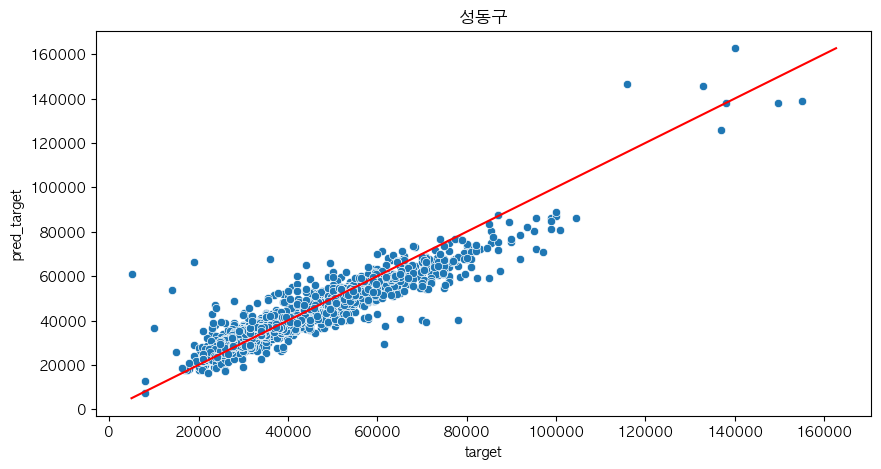

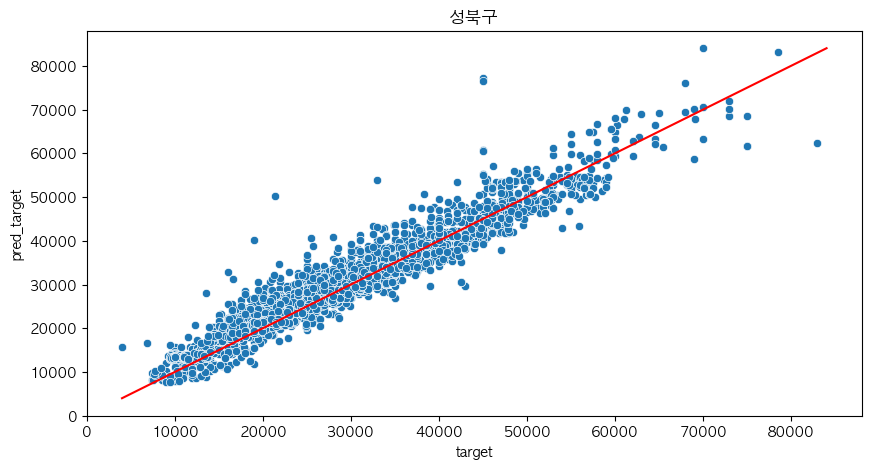

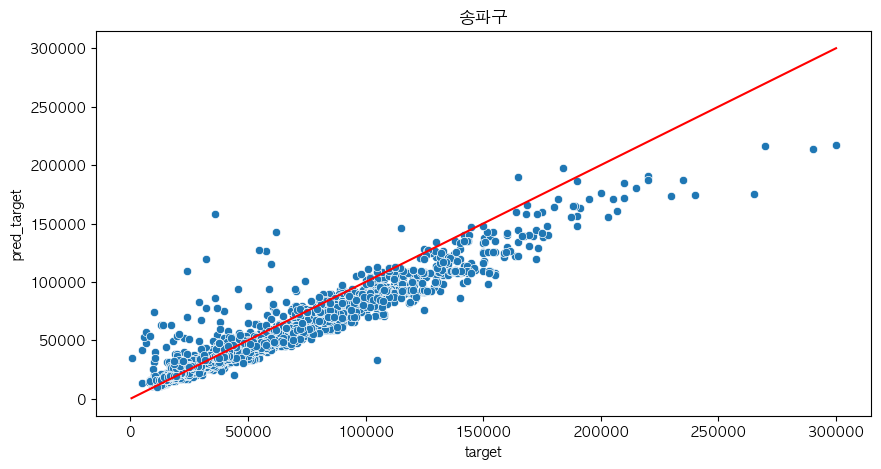

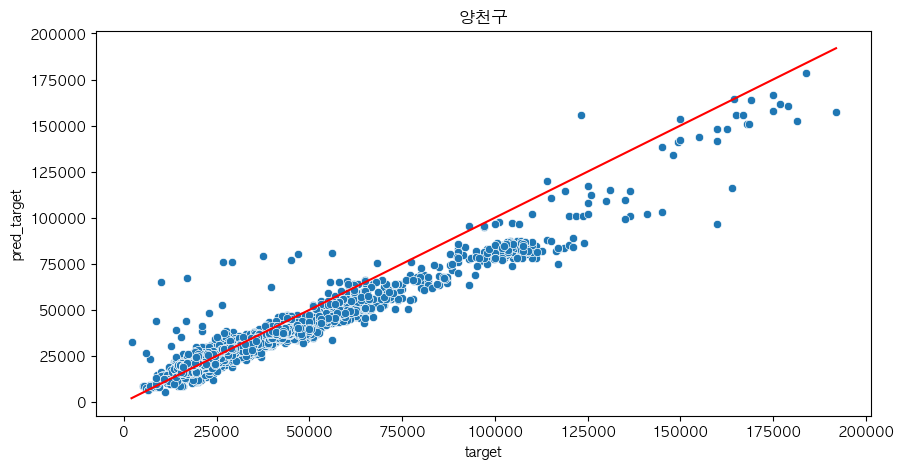

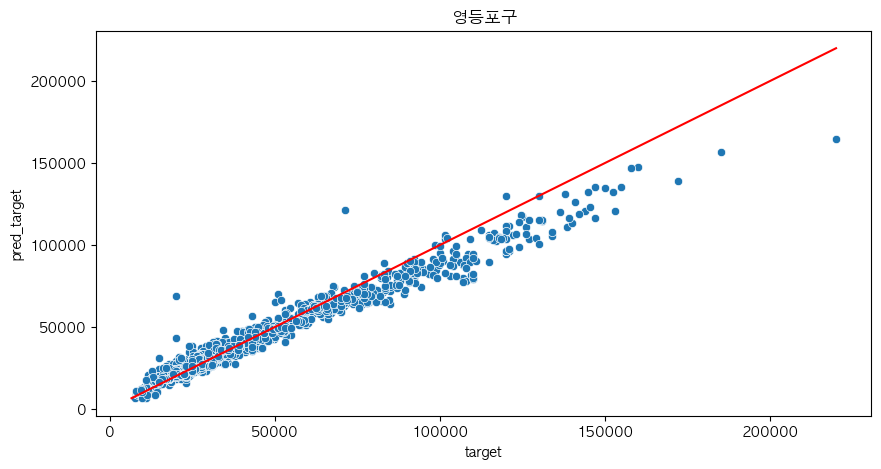

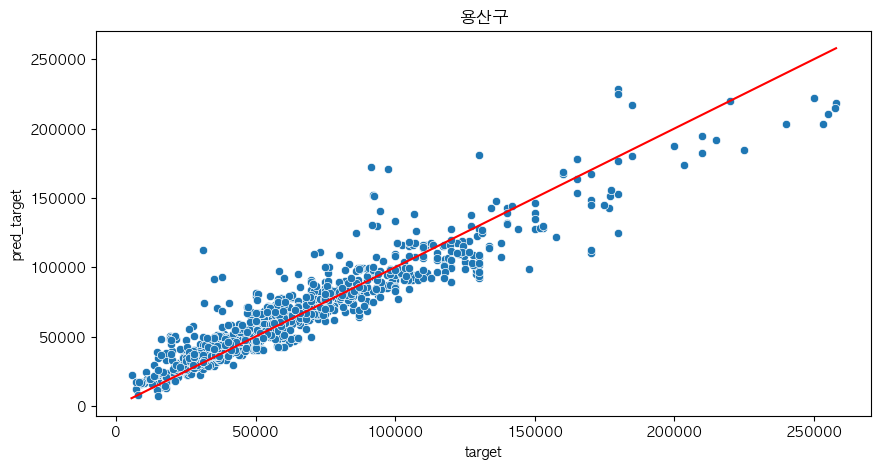

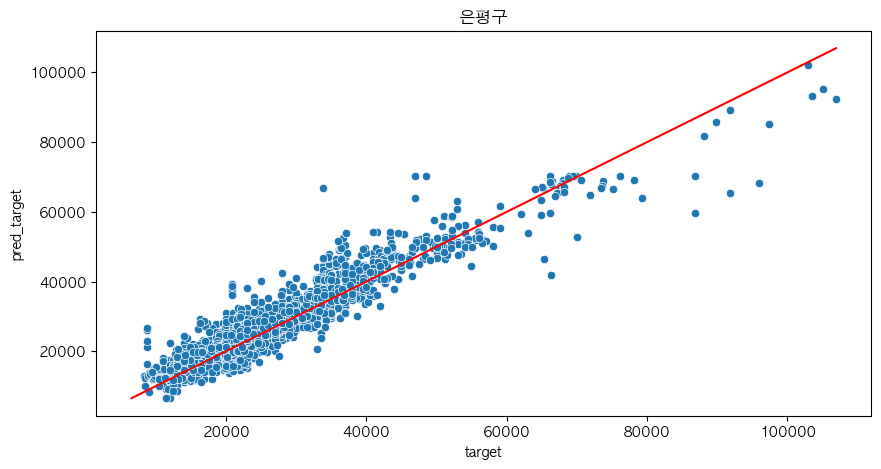

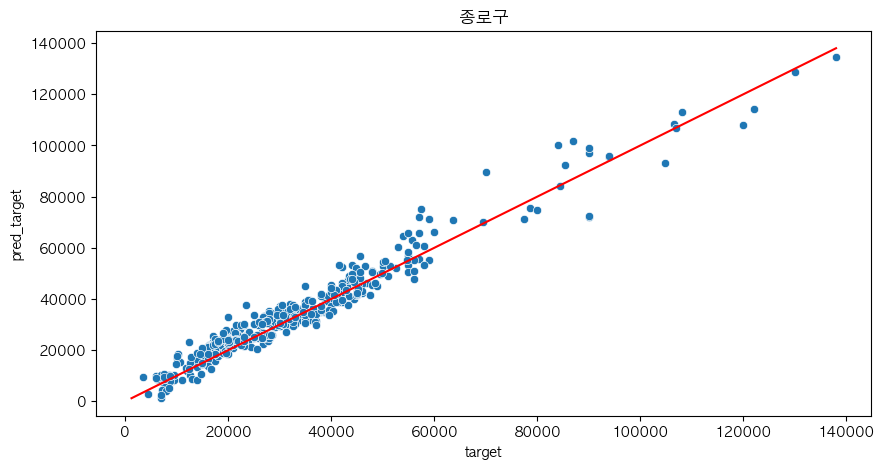

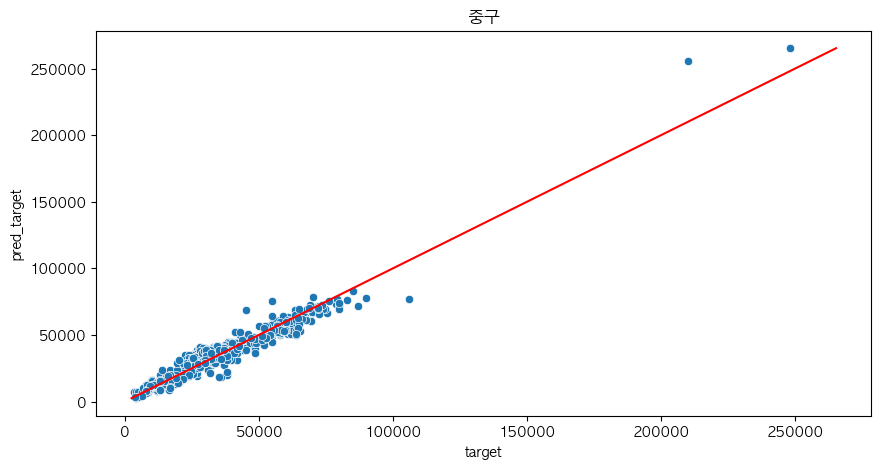

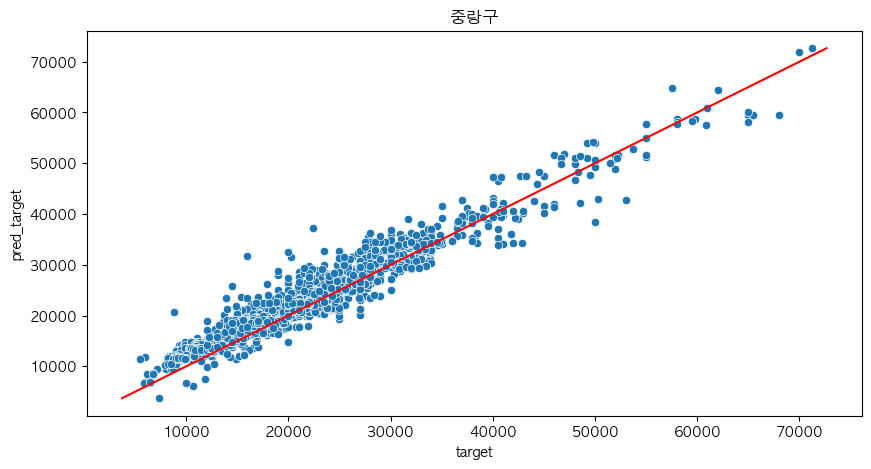

In [41]:
for region in regions:
    chunk = pred_chunks[region]

    plt.figure(figsize=(10, 5))
    plt.title(region)
    sns.scatterplot(data=chunk, x = 'target', y = 'pred_target')
    min_val = min(chunk['target'].min(), chunk['pred_target'].min())
    max_val = max(chunk['target'].max(), chunk['pred_target'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r-', label='y=x')




In [29]:
submit = result.sort_values(by = 'id')

display(submit)
print(submit.isnull().sum())

submit['target'] = submit['target'] * 1.065
submit['target'] = submit['target'].astype(int)
submit.to_csv('region_devision_parking_log_transform.csv', index=False)

,id,target
1118822,1118822,185160.248429
1118823,1118823,261470.654174
1118824,1118824,315943.806913
1118825,1118825,257243.247038
1118826,1118826,201417.042186
...,...,...
1128089,1128089,71672.063064
1128090,1128090,71023.609462
1128091,1128091,79982.455097
1128092,1128092,68662.774017


id        0
target    0
dtype: int64


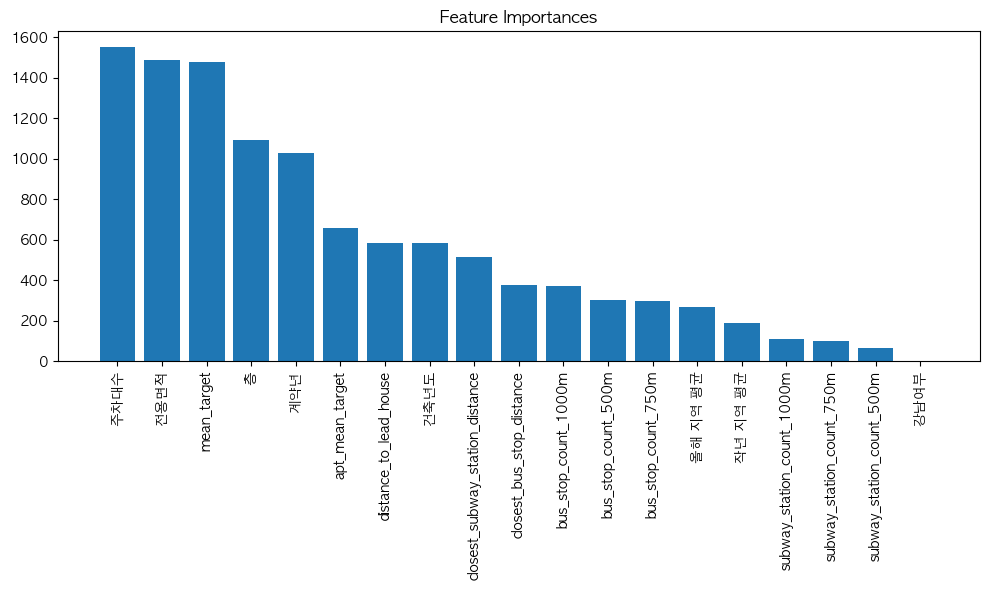

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 특성 중요도와 특성 이름 가져오기
importances = model.feature_importance()

feature_names = X.columns  # X는 특성 데이터프레임

# 중요도에 따라 특성 정렬
indices = np.argsort(importances)[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

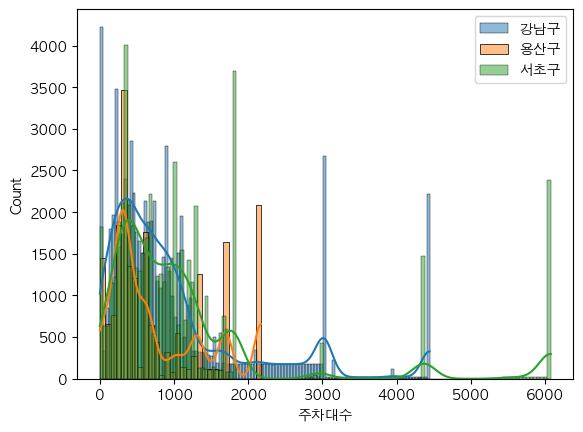

In [14]:
caution_regions = ['강남구', '용산구', '서초구']

for region in caution_regions:
    sns.histplot(data=chunks[region], x='주차대수', kde=True, label = region)
plt.legend()

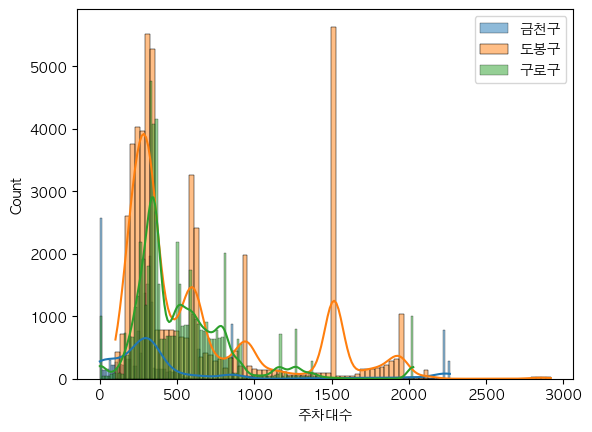

In [15]:
good_regions = ['금천구', '도봉구', '구로구']

for region in good_regions:
    sns.histplot(data=chunks[region], x='주차대수', kde=True, label = region)
plt.legend()